In [1]:
import pandas as pd
import numpy as np
import os, json, math

popsize = 100


def data_generator():
    train_file = '../data/train.csv'
    while True:
        for df in pd.read_csv(train_file, chunksize = 4096):
            if np.random.rand() < 0.5: # drop some frames to reduce the effects of ordering
                continue
            if df.shape[0] < 4096: # the last one is incomplete, i dont know why
                continue
            input_chunk = df.iloc[:,0].copy()
            target = np.mean(df.iloc[:,1])
            yield np.array(input_chunk), target


In [2]:
# define the library object

class addItems(object):
    
    def __init__(self):
        self.name = 'addItems'
    
    def get_arguments(self):
        return [{'name': 'i', 'min': 0, 'max': 4096, 'type': 'int'}, 
                {'name': 'j', 'min': 0, 'max': 4096, 'type': 'int'}, 
                {'name': 'mult', 'min': -2, 'max': 2, 'type': 'float'}, 
                {'name': 'offset', 'min': -10, 'max': 10, 'type': 'float'}]
    
    def __call__(self, array, i=0, j=0, mult=1, offset=0):
        array[i] += array[j]*mult + offset
        return array

class addConditional(object):
    
    def __init__(self):
        self.name = 'addConditional'
    
    def get_arguments(self):
        return [{'name': 'i', 'min': 0, 'max': 4096, 'type': 'int'}, 
                {'name': 'j', 'min': 0, 'max': 4096, 'type': 'int'}, 
                {'name': 'mult', 'min': -2, 'max': 2, 'type': 'float'}, 
                {'name': 'offset', 'min': -10, 'max': 10, 'type': 'float'},
                {'name': 'threshold', 'min': -10, 'max': 10, 'type': 'float'}]
    
    def __call__(self, array, i=0, j=0, mult=1, offset=0, threshold=0):
        if array[j] > threshold:
            array[i] += array[j]*mult + offset
        return array

class relu(object):
    
    def __init__(self):
        self.name = 'relu'
    
    def get_arguments(self):
        return [{'name': 'i', 'min': 0, 'max': 4096, 'type': 'int'}]
    
    def __call__(self, array, i=0):
        array[i] = max(0, array[i])
        return array
        
genetic_base = [addItems(), relu(), addConditional()]

def get_funct_by_name(name):
    for f in genetic_base:
        if f.name == name:
            return f
    # import pdb; pdb.set_trace()
    print('WARNING: Could not resolve function ' + name)
    return None

def get_random_gene():
    num_gene = np.random.randint(len(genetic_base))
    funct = genetic_base[num_gene]
    params_base = funct.get_arguments()
    arguments = dict()
    for param in params_base:
        if param['type'] == 'int':
            val = np.random.randint(param['min'], param['max'])
        elif param['type'] == 'float':
            val = np.random.rand()*(param['max'] - param['min'])+param['min']
        arguments[param['name']] = val
    return funct, arguments
        

In [3]:
class individual(object):
    
    def __init__(self, num_genes=4, infile=None):
        self.functions = []
        self.params = []
        self.fitness = []
        self.fit_val = 999999
        if infile:
            f = open(infile)
            isfirst = True
            for line in f.readlines():
                if isfirst:
                    self.fit_val = float(line)
                    self.fitness.append(self.fit_val)
                    isfirst = False
                else:
                    fname, fparam = line.split('|')
                    funct = get_funct_by_name(fname)
                    if funct:
                        self.functions.append(funct)
                        self.params.append(json.loads(fparam))
            f.close()
        for i in range(num_genes):
            funct, arguments = get_random_gene()
            self.functions.append(funct)
            self.params.append(arguments)
            
    def predict(self, array):
        for i in range(len(self.functions)):
            array = self.functions[i](array, **self.params[i])
        return np.mean(array)
    
    def reset_fitness(self):
        self.fitness = [ self.fit_val ]
    
    def evaluate(self, _array, target):
        array = _array.copy()
        prediction = self.predict(array)
        self.fitness.append(abs(prediction - target))
        self.fit_val = np.mean(self.fitness)
            
ind1 = individual()
for array, target in data_generator():
    predict = ind1.predict(array)
    print(str(target) + ' ' + str(predict))
    break

1.469097487909375 5.1953125


<IPython.core.display.Javascript object>


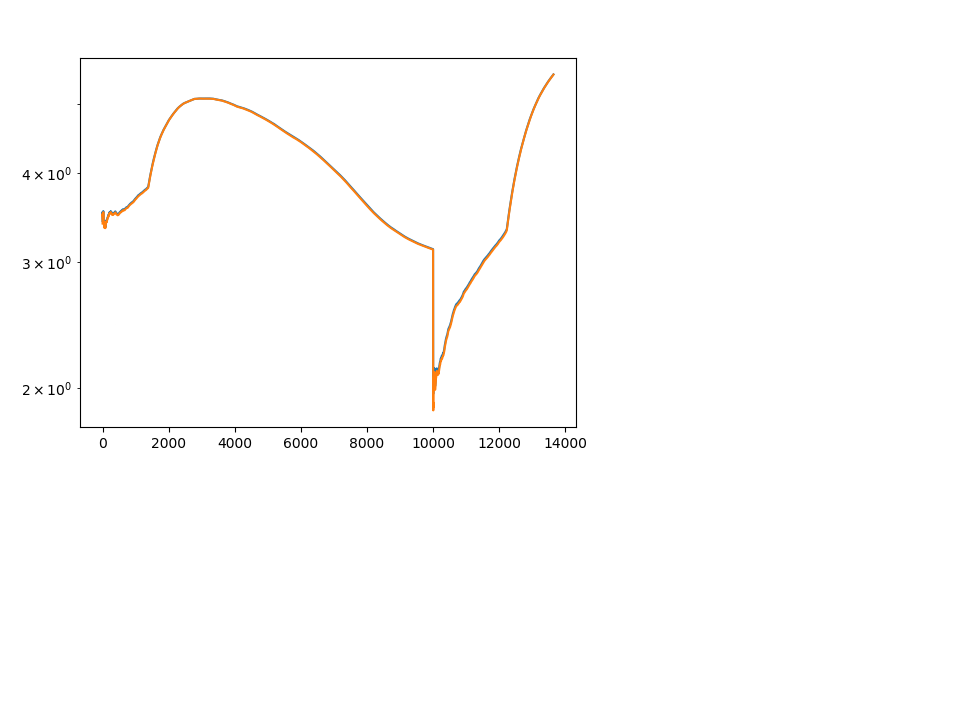

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\lutz.kuenneke\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-3fe207ace6a9>", line 80, in <module>
    ax.clear()
  File "C:\Users\lutz.kuenneke\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py", line 1118, in clear
    self.cla()
  File "C:\Users\lutz.kuenneke\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py", line 1031, in cla
    self._update_transScale()  # needed?
  File "C:\Users\lutz.kuenneke\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\axes\_base.py", line 820, in _update_transScale
    self.xaxis.get_transform(), self.yaxis.get_transform()))
  File "C:\Users\lutz.kuenneke\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\transforms.py", line 1702, in set
    self.invalidate()
  File "C:\Users\lutz.kuen

KeyboardInterrupt: 

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt

# population = []
# popsize = 1000
# for i in range(popsize):
#     population.append(individual(num_genes=10))
    
def evaluate_pop(population, array, target):
    for pop in population:
        pop.evaluate(array, target)
        # best_score = min(pop.fit_val, best_score)
    return population, np.mean([p.fit_val for p in population]), np.min([p.fit_val for p in population])

def remove_loosers(population, frac=0.5):
    population = sorted(population, key = lambda x: x.fit_val)
    for pop in population:
        pop.reset_fitness()
    return population[:int(frac*len(population))]

def fill_population(population, target_size):
    add_prob=1.0/float(target_size)
    if len(population) == 0:
        for i in range(target_size):
            population.append(individual(num_genes=10))
    while len(population) < target_size:
        new_pop = individual(num_genes=np.random.randint(10))
        for pop in population:
            if np.random.rand() <= add_prob:
                # i = np.random.randint(len(pop.functions))
                for i in range(len(pop.functions)):
                    if np.random.rand() < 0.5:
                        new_pop.functions.append(pop.functions[i])
                        new_pop.params.append(pop.params[i])
        population.append(new_pop)
    return population

def save_pop(population):
    # clean the dir before writing
    for file in os.listdir('population/'):
        if 'pop' in file:
            os.remove(os.path.join('population', file))
    for i, p in enumerate(population):
        pfile = 'population/pop' + str(i) + '.pop'
        pf = open(pfile, 'w')
        pf.write(str(p.fit_val) + '\n')
        for j in range(len(p.functions)):
            pf.write(str(p.functions[j].name) + '|' + json.dumps(p.params[j]) + '\n')
        pf.close()

def load_pop():
    population = []
    for file in os.listdir('population/'):
        if 'pop' in file:
            new_pop = individual(infile = os.path.join('population', file))
            population.append(new_pop)
    return population
            
best_scores = []
mean_scores = []
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

population = load_pop()
population = fill_population(population, popsize)
it = 0
for array, target in data_generator():
    it += 1
    population, mean_score, best_score = evaluate_pop(population, array, target)
    if it % 10000 == 0:
        save_pop(population)
        population = remove_loosers(population, frac=0.5)
        population = fill_population(population, popsize)
    mean_scores.append(mean_score)
    best_scores.append(best_score)
    ax.clear()
    ax.semilogy(mean_scores)
    ax.semilogy(best_scores)
    fig.canvas.draw()
    
save_pop(population)
    # ax.clear()